Simple use the FFT to fit history tide data.  

Data from https://tidesandcurrents.noaa.gov/waterlevels.html?id=9414290&units=standard&bdate=20190701&edate=20190801&timezone=GMT&datum=MLLW&interval=6&action=data

In [1]:
import math
import datetime
import pytz
import glob
import functools
import operator
import numpy
import pandas
import matplotlib.pyplot
import matplotlib.pylab
import seaborn
import sklearn.linear_model
import sklearn.metrics
import vtreat.cross_plan

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
date_fmt = '%Y/%m/%d %H:%M'
tz = pytz.utc
    
def parse_date(dtstr):
    d0 = datetime.datetime.strptime(dtstr, date_fmt)
    return d0.replace(tzinfo=tz)

base_date_time = datetime.datetime(2001, 1, 1, tzinfo=tz)
cut_date_time = datetime.datetime(2019, 7, 15, tzinfo=tz)

In [3]:
print("TZ NAME: {tz}".format(tz=base_date_time.tzname()))

TZ NAME: UTC


In [4]:
d0 = parse_date('2001/01/01 00:00')
(d0 - base_date_time).total_seconds()

0.0

In [5]:
print("TZ NAME: {tz}".format(tz=d0.tzname()))

TZ NAME: UTC


In [6]:
tides = pandas.read_pickle('tides.pickle.gz')

In [7]:
tides['train'] = tides['dt']<cut_date_time

In [8]:
tides.head()

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),dt,dts,tide feet,train
0,2017/01/01,00:00,1.849,NaN,2.12,2017-01-01 00:00:00+00:00,504921600.0,2.12,True
1,2017/01/01,00:06,1.695,NaN,1.97,2017-01-01 00:06:00+00:00,504921960.0,1.97,True
2,2017/01/01,00:12,1.543,NaN,1.88,2017-01-01 00:12:00+00:00,504922320.0,1.88,True
3,2017/01/01,00:18,1.393,NaN,1.78,2017-01-01 00:18:00+00:00,504922680.0,1.78,True
4,2017/01/01,00:24,1.247,NaN,1.66,2017-01-01 00:24:00+00:00,504923040.0,1.66,True


In [9]:
dtrain = tides.loc[tides['train'], :].copy()
dtrain.reset_index(inplace=True, drop=True)

In [10]:
xform = numpy.fft.fft(dtrain['tide feet'])

In [11]:
cutoff = 10**math.floor(numpy.log(-numpy.sort(-abs(xform))[20])/numpy.log(10))
cutoff

10000

In [12]:
pick = abs(xform)>=cutoff
sum(pick)

65

In [13]:
xform[numpy.logical_not(pick)] = 0j

In [14]:
back = numpy.real(numpy.fft.ifft(xform))

In [15]:
dtrain['fft approx'] = back

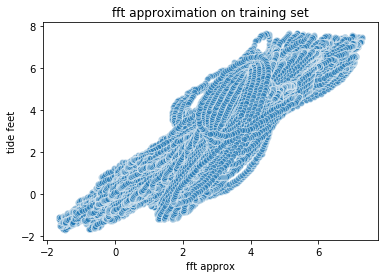

In [16]:
seaborn.scatterplot(x='fft approx', y='tide feet', 
                    data=dtrain, 
                    alpha=0.5)
info = matplotlib.pyplot.title("fft approximation on training set")

In [17]:
sklearn.metrics.r2_score(dtrain['tide feet'], dtrain['fft approx'])

0.9358390398073231

In [18]:
# freqs are defined as cycles per sample spacing
freqs = numpy.fft.fftfreq(dtrain.shape[0])
freqs = numpy.sort(numpy.unique([abs(f) for f in freqs[pick]]))
freqs = [f for f in freqs if f > 0]

In [19]:
sample_spacing_seconds = dtrain['dts'][1] - dtrain['dts'][0]

In [20]:
periods_seconds = [sample_spacing_seconds/f for f in freqs]

In [21]:
vars = []
for ps in periods_seconds:
    vs = 'sin(second/' + str(ps) + ')'
    dtrain[vs] = numpy.sin(2*numpy.pi*dtrain['dts']/ps)
    tides[vs] = numpy.sin(2*numpy.pi*tides['dts']/ps)
    vc = 'cos(second/' + str(ps) + ')'
    dtrain[vc] = numpy.cos(2*numpy.pi*dtrain['dts']/ps)
    tides[vc] = numpy.cos(2*numpy.pi*tides['dts']/ps)
    vars = vars + [vs, vc]
    

In [22]:
fitter = sklearn.linear_model.ElasticNet(fit_intercept=True, 
                                         alpha = 1e-4,
                                         max_iter=10000)
fitter.fit(dtrain[vars], dtrain['tide feet'])
#fitter.coef_

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=10000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
dtrain['predict'] = fitter.predict(dtrain[vars])

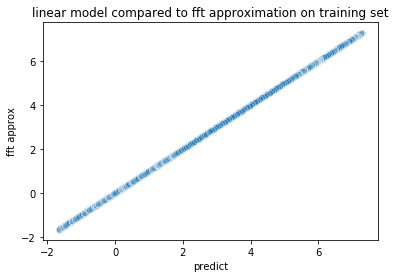

In [24]:
seaborn.scatterplot(x='predict', y='fft approx', 
                    data=dtrain, alpha=0.5)
info = matplotlib.pyplot.title("linear model compared to fft approximation on training set")

Now try to extrapolate.

In [25]:
tides['predict'] = fitter.predict(tides[vars])

In [26]:
dtest = tides.loc[numpy.logical_not(tides['train']), :].copy()
dtest.reset_index(inplace=True, drop=True)

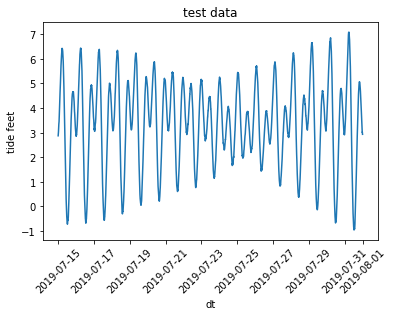

In [27]:
seaborn.lineplot(x='dt', y='tide feet', 
                 data=dtest)
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("test data")

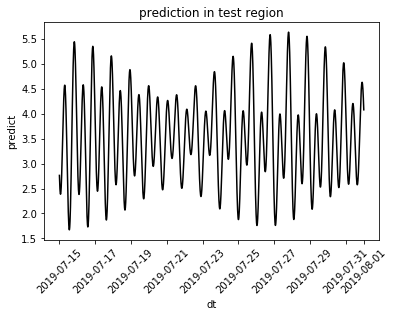

In [28]:
seaborn.lineplot(x='dt', y='predict', 
                 data=dtest, color='black')
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("prediction in test region")

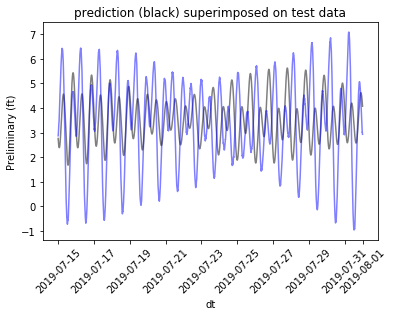

In [29]:
test_plot = tides.loc[numpy.logical_not(tides['train']), :]
seaborn.lineplot(x='dt', y='predict', 
                 data=test_plot,
                 color='black',
                 alpha=0.5)
seaborn.lineplot(x='dt', y='Preliminary (ft)', 
                 data=test_plot, 
                 color='blue',
                 alpha=0.5)
info = matplotlib.pylab.xticks(rotation=45)
info = matplotlib.pyplot.title("prediction (black) superimposed on test data")

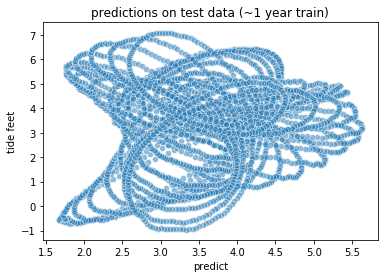

In [30]:
seaborn.scatterplot(x='predict', y='tide feet', 
                    data=dtest, 
                    alpha=0.5)
info = matplotlib.pyplot.title("predictions on test data (~1 year train)")

In [31]:
sklearn.metrics.r2_score(dtest['tide feet'], dtest['predict'])

-0.18455941962317124